In [1]:
from strikepoint.driver import LeptonDriver
from IPython.display import Image, display
import cv2
import numpy as np

driver = LeptonDriver()

Camera Status: 0, Command Count: 0
Radiometry enabled: 1
AGC enabled: 0


In [2]:
def showFrame(frame):
    ok, buf = cv2.imencode('.png', frame)
    if not ok:
        raise RuntimeError("Could not encode frame to PNG")
    display(Image(data=buf.tobytes()))

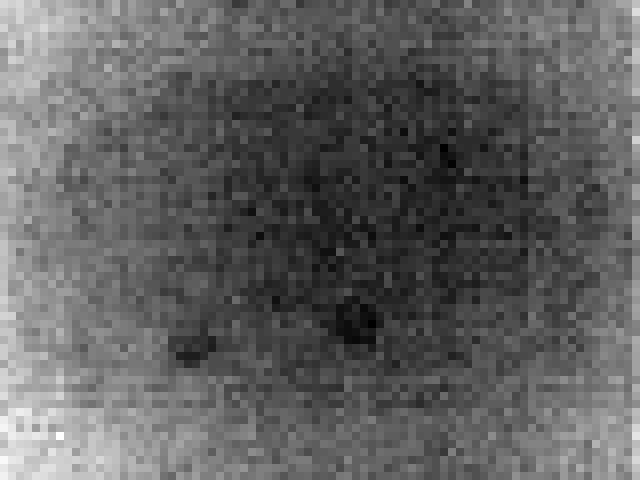

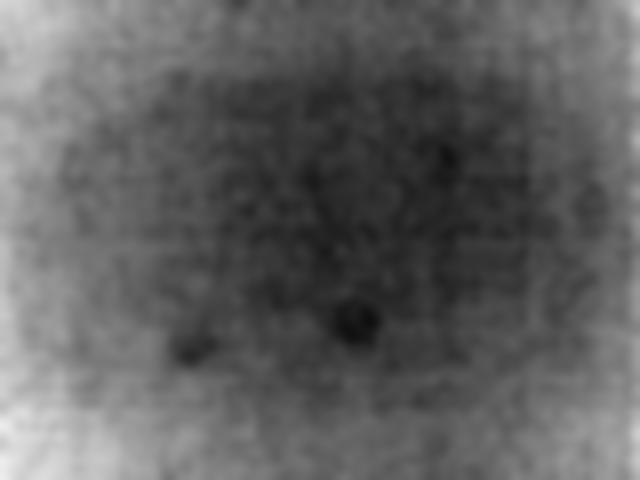

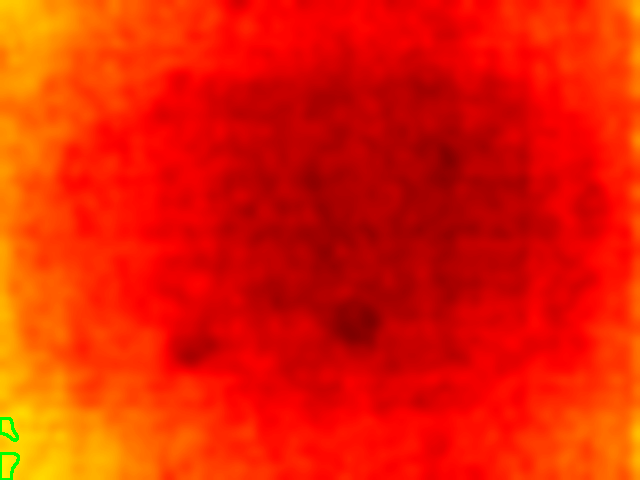

In [7]:
frameList = list(driver.get_frame(True) for _ in range(4))
frame = np.mean(frameList, axis=0)

frame = driver.get_frame(True)
outFrame = cv2.resize(frame, (frame.shape[1]*8, frame.shape[0]*8),
                      interpolation=cv2.INTER_NEAREST_EXACT)
outFrame = cv2.normalize(
    outFrame, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
showFrame(outFrame)
outFrame = cv2.GaussianBlur(outFrame, (33, 33), 0)
showFrame(outFrame)

_, thresh = cv2.threshold(outFrame, 220, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(
    thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

outFrame = cv2.normalize(
    outFrame, None, 50, 200, cv2.NORM_MINMAX).astype(np.uint8)
outFrame = cv2.applyColorMap(outFrame, cv2.COLORMAP_HOT)
cv2.drawContours(outFrame, contours, -1, (0, 255, 0), 2)

showFrame(outFrame)